# Viinin hinnan määrittäminen
Viiniarvosteludata haettu kagglesta: https://www.kaggle.com/zynicide/wine-reviews



In [ ]:
api_token = {"username":"tuomak","key":"c038dd636abfab5189aac36dc1f7cbfc"}
import json
import zipfile
import os
#os.mkdir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle datasets download -d zynicide/wine-reviews
#os.chdir('/content/wine-reviews')
for zip_file in [f for f in os.listdir() if os.path.splitext(f)[-1] == '.zip']:
    zip_ref = zipfile.ZipFile(zip_file, 'r')
    zip_ref.extractall()
    zip_ref.close()

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
wine-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from sklearn.linear_model import ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [ ]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [ ]:
num_cols = ['points', 'price']
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   points  129971 non-null  int64  
 1   price   129971 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.0 MB


In [ ]:
for col in df.columns:
  if df[col].dtype == 'object':
    print(col)

country
description
designation
province
region_1
region_2
taster_name
taster_twitter_handle
title
variety
winery


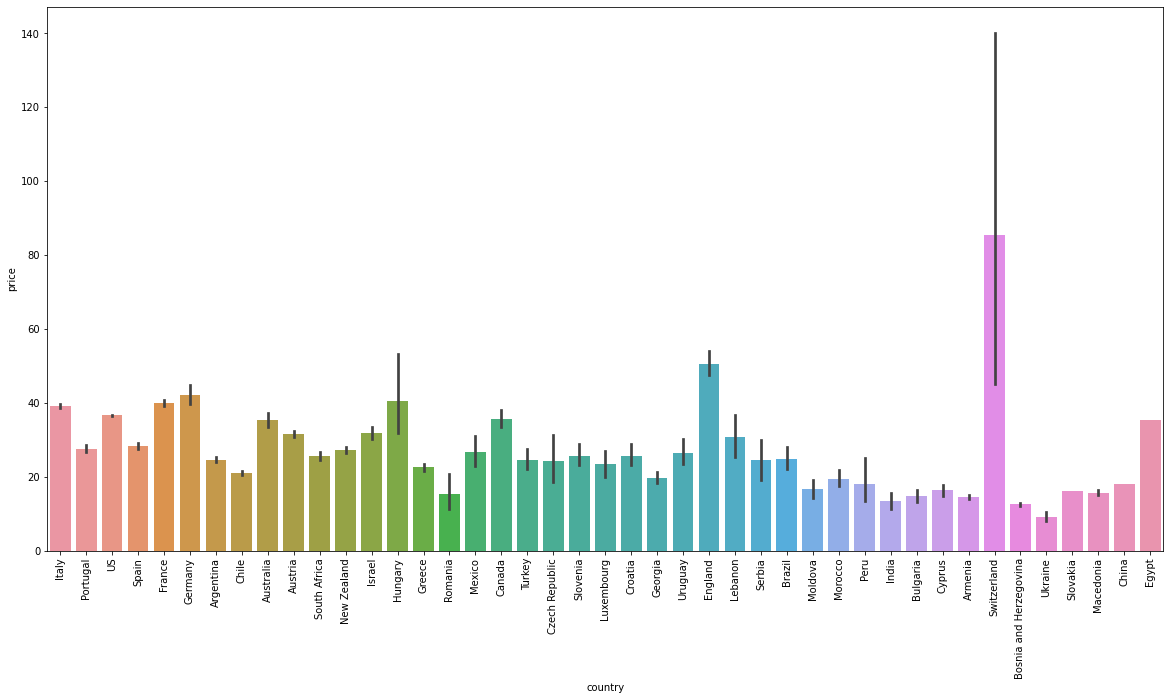

In [ ]:
fig, ax = plt.subplots(figsize=[20, 10])
plt.xticks(rotation=90)
sns.barplot(x='country', y='price', data=df, ax=ax,);

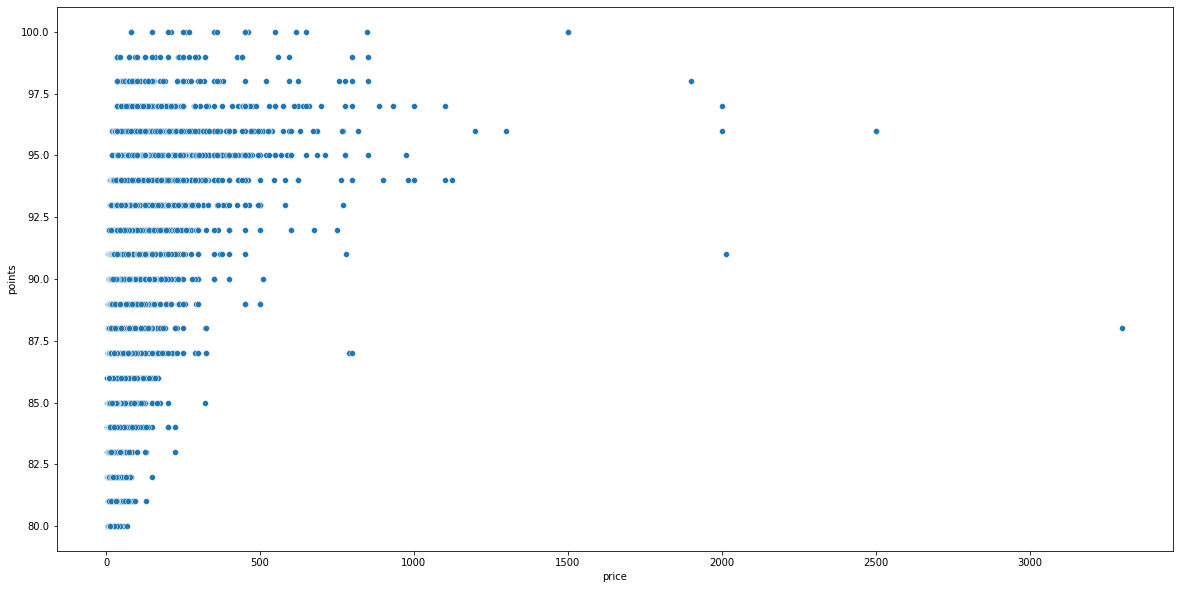

In [ ]:
fig, ax = plt.subplots(figsize=[20, 10])
# plt.xticks(rotation=90)
sns.scatterplot(y='points', x='price', data=df, ax=ax );

In [ ]:
feature_cols = ['points', 'province', 'region_1', 'region_2', 'variety', 'winery']
features = df[feature_cols].dropna()
labels = df['price'][features.index].to_numpy()
features

,points,province,region_1,region_2,variety,winery
2,87,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm
4,87,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks
10,87,California,Napa Valley,Napa,Cabernet Sauvignon,Kirkland Signature
12,87,California,Alexander Valley,Sonoma,Cabernet Sauvignon,Louis M. Martini
14,87,California,Central Coast,Central Coast,Chardonnay,Mirassou
...,...,...,...,...,...,...
129945,90,California,Santa Ynez Valley,Central Coast,Chenin Blanc,Birichino
129949,90,California,Napa Valley,Napa,Chardonnay,Flora Springs
129950,90,California,Napa Valley,Napa,Zinfandel,Hendry
129952,90,California,Chiles Valley,Napa,Zinfandel,Houdini


In [ ]:
encoded_features = features.copy()
encoders = {}

for column in [col for col in features[feature_cols].columns if features[col].dtype == 'object']:
  le = LabelEncoder()
  encoded_features[column] = le.fit_transform(features[column].to_list())
  encoders[column] = le

encoded_features = encoded_features.to_numpy()

(50511,)

In [41]:
print(encoded_features.shape,
labels.shape)
print(X_train.shape,
y_train.shape)

(50511, 6) (50511,)
(40408, 6) (40408,)


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(encoded_features, labels, test_size=0.2)

models = {
    'ElasticNetCV': ElasticNetCV(),
    'LarsCV': LarsCV(),
    'LassoCV': LassoCV(),
    'LassoLarsCV': LassoLarsCV(),
    'OrthogonalMatchingPursuitCV': OrthogonalMatchingPursuitCV(),
    #'SVR': SVR()
}

for name, model in models.items():
  try:
    model.cv = kfold
  except:
    pass
  models[name] = model.fit(X_train, y_train)
  print(f'{name} finished with score of {round(model.score(X_test, y_test), 3)}')

ElasticNetCV finished with score of 0.294
LarsCV finished with score of 0.295
LassoCV finished with score of 0.295
LassoLarsCV finished with score of 0.295
OrthogonalMatchingPursuitCV finished with score of 0.295
